# Unsupervised Learning Challange: Boston Marathon -- Kristofer Schobert

In this assignment, we will use data from the 2014 Boston Marathon. Each row contains information on each runner of the marathon. We will try to cluster the data by gender (male vs female runner). We have the ground truth in our dataset, thus we can evaluate the clustering techniques via this ground truth. 

First, we explore the data, removing rows and columns we find unnecessary. Then we attempt to create some features that may help separate men and women. Finally, we evaluate our different clustering algotithms. Unfortunately, I was unable to achieve clustering that separated the genders well. This seems to be a really difficult task. I wonder if doing this well is even possible given the data we have.

Even through I was unable to seperate the genders by clustering well, I still feel a got a lot out of this assignment. 

In [1]:
# importing packages

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, homogeneity_score, v_measure_score
from sklearn.cluster import MeanShift, estimate_bandwidth


In [3]:
# importing the dataframe
data_path = ('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df = pd.read_csv(data_path)
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
# All wheelchair racers' bibs begin with "W". We want to only include people who physicially ran. 
# Thus, we search in the column 'bib' for entries that do not contain a "W".

df[df['bib'].str.contains('W') == False].head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
5,32.58,"Sumgong, Jemima Jelagat",4,82.45,F,29,140.68,F3,4,NaN,...,28,5.37,NaN,99.33,16.22,69.47,65.83,KEN,Nandi,132.95
7,30.48,"Geneti, Markos",5,76.95,M,29,129.83,5,5,NaN,...,5,4.97,NaN,92.52,15.17,64.85,61.62,ETH,Addis Ababa,122.80
9,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,NaN,...,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83


In [6]:
# df is now the dataframe with only runners
df = df[df['bib'].str.contains('W') == False].copy()

In [7]:
# What are the columns for this dataframe?
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

In [9]:
# How many unique divisions are there?
df.division.nunique()

6979

In [10]:
# How many unique gender divisions are there?
df.genderdiv.nunique()

17575

In [11]:
# is Division often difference from gender division... Yes.
pd.Series(df.division == df.genderdiv).describe()

count     31931
unique        2
top       False
freq      31887
dtype: object

In [12]:
# how many null values are in each column?
df.isnull().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30690
35k              0
overall          0
pace             0
state         2557
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

We should probably drop ctz, let's also drop state. 

In [13]:
# how many unique cities do we have?
df.city.nunique()

5913

Man, that is a lot of cities, which means a lot of columns. 



Let's get rid of columns that will not help up with clustering the runners by gender. 

We will drop division and genderdiv because there are too many divisions and I assume (I could be wrong) it is not ordinal. We will also drop name, bib, ctz, state, city, and country. 

Would the runners hometown or home country help us in clustering them as male or female... Maybe. Perhaps, only male runners would come from a certain country or city. Maybe a certain city would have a "Women Who Run" community group, and their group takes a bus trip every year to the Boston Marathon.  

Still let's drop these columns. Let's try to cluster the data my their run times, age, pace and overall rank (e.g. 34th place) in the marathon. 

In [14]:
# dropping unwanted columns
df = df.drop(['name', 'division', 'bib', 'genderdiv', 'ctz', 'state', 'country', 'city'], 1).copy()

In [15]:
# let's see lots of rows of df
df

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,half,20k,40k
1,32.58,82.43,F,33,138.95,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
3,32.57,82.43,F,24,140.58,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
5,32.58,82.45,F,29,140.68,116.37,28,5.37,99.33,16.22,69.47,65.83,132.95
7,30.48,76.95,M,29,129.83,107.47,5,4.97,92.52,15.17,64.85,61.62,122.80
9,30.48,77.68,M,31,137.83,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83
10,32.58,82.45,F,30,143.00,116.92,40,5.47,99.35,16.22,69.47,65.85,134.65
11,30.52,76.97,M,28,128.80,107.47,2,4.92,92.52,15.18,64.87,61.63,121.95
13,32.58,85.55,F,33,152.07,124.22,121,5.80,104.62,16.22,71.10,67.15,143.50
15,33.93,85.03,F,30,143.90,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47
17,32.57,82.43,F,26,139.98,116.38,25,5.35,99.35,16.20,69.47,65.83,132.65


We see that some of the enteries are dashes. This will be an issue. We should get drid of these rows.

In [16]:
# if we have dashes in some columns, then those columns are not numerical types...
df.dtypes

10k          object
25k          object
gender       object
age           int64
official    float64
35k          object
overall       int64
pace        float64
30k          object
5k           object
half         object
20k          object
40k          object
dtype: object

In [17]:
# creating a loop to turn all columns other than 'gender' into numerical values. Many of them are strings. 
# The dashes should become NaN values
for column_name in df.drop(['gender'], 1).columns:
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')


In [18]:
# the dashes should be NaN values now
df

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,half,20k,40k
1,32.58,82.43,F,33,138.95,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
3,32.57,82.43,F,24,140.58,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
5,32.58,82.45,F,29,140.68,116.37,28,5.37,99.33,16.22,69.47,65.83,132.95
7,30.48,76.95,M,29,129.83,107.47,5,4.97,92.52,15.17,64.85,61.62,122.80
9,30.48,77.68,M,31,137.83,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83
10,32.58,82.45,F,30,143.00,116.92,40,5.47,99.35,16.22,69.47,65.85,134.65
11,30.52,76.97,M,28,128.80,107.47,2,4.92,92.52,15.18,64.87,61.63,121.95
13,32.58,85.55,F,33,152.07,124.22,121,5.80,104.62,16.22,71.10,67.15,143.50
15,33.93,85.03,F,30,143.90,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47
17,32.57,82.43,F,26,139.98,116.38,25,5.35,99.35,16.20,69.47,65.83,132.65


In [19]:
#making sure all data types are numerical (other than gender)
df.dtypes

10k         float64
25k         float64
gender       object
age           int64
official    float64
35k         float64
overall       int64
pace        float64
30k         float64
5k          float64
half        float64
20k         float64
40k         float64
dtype: object

In [20]:
# dropping the rows with nan values
df = df.dropna().copy()

In [21]:
# do we have a class imbalance?
df.gender.describe()

count     31596
unique        2
top           M
freq      17442
Name: gender, dtype: object

Alright, we only have two unique genders types, and we do not have a class imbalance issue 17422/31596 is roughly 55%. We have 55% males and 45% females.

Let's create some features. We have the amount of time it took each runner to run a certain length of the race. Perhaps, the fraction of an individual's total runtime from one distance checkpoint to the next will be helpful. For instance, maybe women spend a 15% of their time between the 10k mark and the 20k mark, while men spend, on average, 18%. Maybe women finishing quickly (a low percentage between the finish line and the 40k mark) while men finish more quickly. 

In [22]:
# we have these intervals
# 5k 10k 20k half 25k 30k 35k 40k official
# why is there no 15k???

# again this is the FRACTION of the individuals overall race. the entry 0_5 
# (the fraction of their time spent from start to the 5k mark) is different than 5k
# (the amount of time elapsed until they reach the 5k mark)
df['0_5'] = df['5k']/df['official']
df['5_10'] = (df['10k'] - df['5k'])/df['official']
df['10_20'] = (df['20k'] - df['10k'])/df['official']
df['20_half'] = (df['half'] - df['20k'])/df['official']
df['half_25'] = (df['25k'] - df['half'])/df['official']
df['25_30'] = (df['30k'] - df['25k'])/df['official']
df['30_35'] = (df['35k'] - df['30k'])/df['official']
df['35_40'] = (df['40k'] - df['35k'])/df['official']
df['40_official'] = (df['official'] - df['40k'])/df['official']

In [23]:
df.iloc[0,-9:].sum()

1.0

Excellent! the sum for all the fractions is 1. This is what we want. 

Now do we include all of the other columns? Lets just use all these fractional differences. I'd like to see where this goes. Maybe this is really helpful.



In [24]:
df_diff = df.iloc[:,-9:]
df_diff['official'] = df['official']
df_diff['gender'] = df['gender']
df_diff

,0_5,5_10,10_20,20_half,half_25,25_30,30_35,35_40,40_official,official,gender
1,0.116733,0.117740,0.239295,0.026196,0.093271,0.121626,0.122634,0.113206,0.049298,138.95,F
3,0.115237,0.116446,0.236591,0.025893,0.092190,0.120216,0.121212,0.117940,0.054275,140.58,F
5,0.115297,0.116292,0.236352,0.025874,0.092266,0.119989,0.121126,0.117856,0.054947,140.68,F
7,0.116845,0.117923,0.239852,0.024879,0.093199,0.119926,0.115151,0.118077,0.054148,129.83,M
9,0.109918,0.111224,0.227091,0.025031,0.090329,0.124066,0.126895,0.127403,0.058043,137.83,M
10,0.113427,0.114406,0.232657,0.025315,0.090769,0.118182,0.122867,0.123986,0.058392,143.00,F
11,0.117857,0.119099,0.241537,0.025155,0.093944,0.120730,0.116071,0.112422,0.053183,128.80,M
13,0.106661,0.107582,0.227330,0.025975,0.095022,0.125403,0.128888,0.126784,0.056356,152.07,F
15,0.117582,0.118207,0.236206,0.026129,0.092773,0.120709,0.120083,0.116678,0.051633,143.90,F
17,0.115731,0.116945,0.237605,0.026004,0.092585,0.120874,0.121660,0.116231,0.052365,139.98,F


In [25]:
# Seeing how kmeans does at clustering this df_diff into a male and female cluster. 
# We will only use two clusters
# Let's see the crosstab matrix and adjusted_rand_score

from sklearn.preprocessing import scale
X_unscaled = df_diff.drop(['gender'], 1)
X = scale(X_unscaled)
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
y_true = df.gender

print(pd.crosstab(y_pred, y_true))
print(adjusted_rand_score(y_true, y_pred))

gender     F      M
row_0              
0       4503   6312
1       9651  11130
-0.0009976112971790668


Wow, that is performing poorly. Males and Females populate each cluster very evenly.

Maybe just using the runners who ran in under 275 min will be better. These runners are more in shape, and thus maybe show the capabilities of male vs female bodies better? Thus better clustering?

In [26]:
df_diff[df_diff['official'] < 275].groupby(['gender']).mean()

,0_5,5_10,10_20,20_half,half_25,25_30,30_35,35_40,40_official,official
gender,,,,,,,,,,
F,0.110299,0.110786,0.226452,0.024763,0.092006,0.123233,0.128683,0.128294,0.055484,229.714680
M,0.109890,0.109873,0.223367,0.024514,0.090172,0.121802,0.129394,0.132695,0.058291,211.368343


The means for these intervals really don't look that different. The most noticable is the last stretch of the race '40_official'. We have a differnce of like 1/20th. Let's see how k-means does. 

In [27]:
from sklearn.preprocessing import scale
X_unscaled = df_diff[df_diff['official'] < 275].drop(['gender'], 1)
X = scale(X_unscaled)
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
y_true = df_diff[df_diff['official'] < 275].gender

print(pd.crosstab(y_pred, y_true))
print(adjusted_rand_score(y_true, y_pred))

gender     F     M
row_0             
0       7350  8769
1       2870  5061
-0.0016214484775882063


Well this is not going well at all. Not sure if this 275min cutoff is helpful but I would like to continue using it.

Maybe just looking at the start and end will help? There is a big difference in the means of men vs women there. 

In [28]:
# creating new dataframe for individuals who completed the marathon in under 275 minutes. 
df_fast = df_diff[df_diff['official'] < 275]
df_fast_ends = df_diff[df_diff['official'] < 275][['0_5', '40_official','gender']]


In [29]:
from sklearn.preprocessing import scale
X_unscaled = df_fast_ends.drop(['gender'], 1)
X = scale(X_unscaled)
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
y_true = df_fast_ends.gender

print(pd.crosstab(y_pred, y_true))
print(adjusted_rand_score(y_true, y_pred))

gender     F     M
row_0             
0       2991  5487
1       7229  8343
0.0013072071460727324


That is not much better at all. It is still performing very poorly.

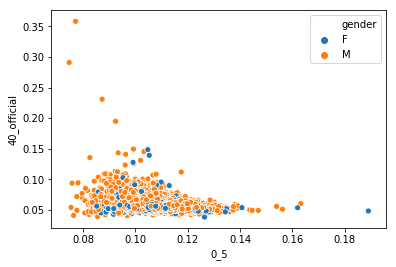

In [30]:
sns.scatterplot(x='0_5', y='40_official', hue='gender', data=df_fast_ends)


Yes, this looks very hard to cluster. I did notice something earlier that may be helpful.

In [31]:
df_fast.groupby(['gender']).std()

,0_5,5_10,10_20,20_half,half_25,25_30,30_35,35_40,40_official,official
gender,,,,,,,,,,
F,0.006151,0.005336,0.008171,0.000961,0.004033,0.004952,0.007357,0.009855,0.004586,22.983156
M,0.007120,0.006382,0.010686,0.001210,0.003973,0.005897,0.009477,0.014030,0.007718,29.952677


If we look at the spread of fractions of runtimes towards the end of the race (particularly 25_30, 30_35, 35_40) we see that in aggregate the men spread more. They are less consistant towards the end. The weomen however are more consistant. This leads me to believe that maybe the spread of a man's three 5km segments is greater than a woman's. Let's create that feature.

In [32]:

df_fast['end_std'] = df_fast.iloc[:,5:8].agg("std", axis="columns")


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
# runing k-means again with this new feature.

from sklearn.preprocessing import scale
X_unscaled = df_fast.drop(['gender'], 1)
X = scale(X_unscaled)
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
y_true = df_fast.gender

print(pd.crosstab(y_pred, y_true))
print(adjusted_rand_score(y_true, y_pred))

gender     F     M
row_0             
0       2507  4876
1       7713  8954
-0.0011963861994737281


Again this is no bettter. 

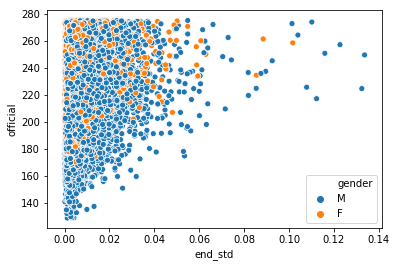

In [34]:
sns.scatterplot(x='end_std', y='official', hue='gender', hue_order= ['M', 'F'], data=df_fast)

There is really only one cluster here. Maybe the females are a cluster within the male cluster. I am not sure how to deal with that though.

Let's just try using all the features we have and that we have created. Back to the original df.

In [35]:
df.head()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,...,40k,0_5,5_10,10_20,20_half,half_25,25_30,30_35,35_40,40_official
1,32.58,82.43,F,33,138.95,116.37,21,5.30,99.33,16.22,...,132.10,0.116733,0.117740,0.239295,0.026196,0.093271,0.121626,0.122634,0.113206,0.049298
3,32.57,82.43,F,24,140.58,116.37,27,5.37,99.33,16.20,...,132.95,0.115237,0.116446,0.236591,0.025893,0.092190,0.120216,0.121212,0.117940,0.054275
5,32.58,82.45,F,29,140.68,116.37,28,5.37,99.33,16.22,...,132.95,0.115297,0.116292,0.236352,0.025874,0.092266,0.119989,0.121126,0.117856,0.054947
7,30.48,76.95,M,29,129.83,107.47,5,4.97,92.52,15.17,...,122.80,0.116845,0.117923,0.239852,0.024879,0.093199,0.119926,0.115151,0.118077,0.054148
9,30.48,77.68,M,31,137.83,112.27,20,5.27,94.78,15.15,...,129.83,0.109918,0.111224,0.227091,0.025031,0.090329,0.124066,0.126895,0.127403,0.058043


In [36]:
df.columns

Index(['10k', '25k', 'gender', 'age', 'official', '35k', 'overall', 'pace',
       '30k', '5k', 'half', '20k', '40k', '0_5', '5_10', '10_20', '20_half',
       'half_25', '25_30', '30_35', '35_40', '40_official'],
      dtype='object')

In [37]:
#creating end_std feature on our original dataframe
df['end_std'] = df.iloc[:,18:21].agg("std", axis="columns")

In [38]:
df.head()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,...,0_5,5_10,10_20,20_half,half_25,25_30,30_35,35_40,40_official,end_std
1,32.58,82.43,F,33,138.95,116.37,21,5.30,99.33,16.22,...,0.116733,0.117740,0.239295,0.026196,0.093271,0.121626,0.122634,0.113206,0.049298,0.005177
3,32.57,82.43,F,24,140.58,116.37,27,5.37,99.33,16.20,...,0.115237,0.116446,0.236591,0.025893,0.092190,0.120216,0.121212,0.117940,0.054275,0.001677
5,32.58,82.45,F,29,140.68,116.37,28,5.37,99.33,16.22,...,0.115297,0.116292,0.236352,0.025874,0.092266,0.119989,0.121126,0.117856,0.054947,0.001660
7,30.48,76.95,M,29,129.83,107.47,5,4.97,92.52,15.17,...,0.116845,0.117923,0.239852,0.024879,0.093199,0.119926,0.115151,0.118077,0.054148,0.002408
9,30.48,77.68,M,31,137.83,112.27,20,5.27,94.78,15.15,...,0.109918,0.111224,0.227091,0.025031,0.090329,0.124066,0.126895,0.127403,0.058043,0.001798


Alright, we have all the features we have created and the ones we chose to work with at the start of this treatment. 

## Clustering by Gender

Let's use what we have and see if we cant cluster by gender. I'm doubtful we will be able to cluster well. But let's find out.

## KMeans

In [39]:
from sklearn.preprocessing import scale
X_unscaled = df.drop(['gender'], 1)
X = scale(X_unscaled)
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
y_true = df.gender

print(pd.crosstab(y_pred, y_true))
print(adjusted_rand_score(y_true, y_pred))

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


gender     F      M
row_0              
0       8393  12204
1       5761   5238
0.017805985347644843


That is better than using just the fast runners and only the differences between the distance checkpoints, but it is still remarkably bad. Maybe using more clusters will help?

If we use more clusters the adjusted_rand_score will be less helpful. If there are more predicted clusters than ground truth classes our score will never be 1. At first, I felt that this score would be useless if we had differing amount of ground truth and predicted clusters, but now I am seeing that it can still be a bit helpful.

Let's also calculate the v_measure_score. This score is the harmonic mean of the completeness (all members of a given class are assigned to the same cluster) and homogeneity (each cluster only contains members of the same class).

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


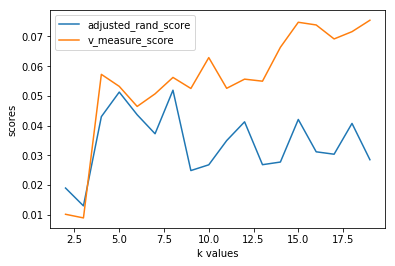

In [40]:
arss = []
v_scores = []
ns = list(range(2,20))
X_unscaled = df.drop(['gender'], 1)
X = scale(X_unscaled)
y_true = df.gender
for n in ns:
    y_pred = MiniBatchKMeans(
        init='random',
        n_clusters=n,
        batch_size=100).fit_predict(X)
    ars = adjusted_rand_score(y_true, y_pred)
    arss.append(ars)
    v_score = v_measure_score(y_true, y_pred)
    v_scores.append(v_score)
plt.plot(ns, arss)
plt.plot(ns,v_scores)
plt.xlabel('k values')
plt.ylabel('scores')
plt.legend(['adjusted_rand_score', 'v_measure_score'])
plt.show()

Here we have the two scores vs the number of clusters for Kmeans clustering. This plot changes some each time we run the code. The adjusted rand score seems to decrease slightly after 5 or so, while v measure score seems to increase after k = 5. It seems any k value between 5 to 10 is a good choice. 

Will mean shift work better?

## Mean Shift

In [41]:
X_unscaled = df.drop(['gender'], 1)
X = scale(X_unscaled)
y_true = df.gender

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples = 300)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

y_pred = ms.predict(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
print("Adjusted Rand Score: {}".format(adjusted_rand_score(y_true, y_pred)))
print("V Measure Score: {}".format(v_measure_score(y_true, y_pred)))

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


Number of estimated clusters: 17
Adjusted Rand Score: -0.0027060440920319635
V Measure Score: 0.006989895298090541


Wow, this was even worse. These are really poor scores. They are esssentially 0. Maybe spectral clusterin will be better.

### Spectral Clustering and Affinity Propagation

These made my computer crash! I tried running these and after about 5 minutes of runtime my computer turned off. I guess we will not be testing these methods of clustering. 


# Conclusion

Clustering the 2014 Boston Marathon runners by their gender is really hard to do. I was not able to do it well. Maybe there is some method to do this, but I was unable to find it. Prehaps one could create some features that really split the men and women apart. I tried a couple ideas out, but they did not work at all. I could imagine plenty of men and women running alongside eachother, thus yielding no difference in their runtime featuers. 

Earlier in my analysis it looked as if the female cluster was contained within of the male cluster. I do not know how to approach that. If the inner female cluster was more dense then one could use the density to determine the inner cluster. But the outer cluster still has members in that inner region. How would the computer know which of those inner points belonged to the bigger cluster or the inner cluster?

Here is a visual of the situation I am talking about.

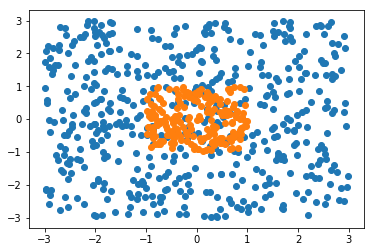

In [55]:
import matplotlib.pyplot as plt
import random
x = np.random.uniform(-3, 3, size=500)
y = np.random.uniform(-3, 3, size=500)

xin = np.random.uniform(-1, 1, size=200)
yin = np.random.uniform(-1, 1, size=200)

plt.scatter(x, y)
plt.scatter(xin, yin)
plt.show()

We have that inner region that is more dense. The comupter could easily declare it is different cluster and cluster all those inner points together. But some points in this regions are from the outer cluster. How would the computer know which points are from the outer cluster? 

Even if the computer clustered all the inner points together as just the inner cluster, it would still be somewhat helpful...

With the knowledge I have and the amount of time I can dedicate to this assignment right now, I will say that k-means with k = 7 is our best unsupervized learning model. We achieve a Adjusted Rand Score and V Measure Score of roughly 0.05. Ouch. 